# Tarea 1
## Redes Neuronales Avanzadas
**Universidad de Guadalajara**  
26 de octubre de 2025

---

### Resumen

El objetivo es revisar el modelo de redes neuronales convolucionales y su implementación en PyTorch. Por favor, suba sus soluciones en un archivo comprimido a Classroom antes del 4 de noviembre.

---

## Problema 1

Realice la implementación en Python de LeNet-5 y úsela para clasificar el conjunto de datos MNIST.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones para MNIST
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # LeNet-5 espera imágenes de 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Media y desviación estándar de MNIST
])

# Descargar y cargar datos MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Usando dispositivo: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.1MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 522kB/s]

100%|██████████| 1.65M/1.65M [00:00<00:00, 4.20MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 7.47MB/s]

Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de prueba: 10000


In [17]:
class LeNet5(nn.Module):
    """
    Implementación de LeNet-5 según el paper original de Yann LeCun (1998).
    
    Arquitectura:
    - C1: Convolución 6 filtros 5x5
    - S2: Pooling promedio 2x2
    - C3: Convolución 16 filtros 5x5
    - S4: Pooling promedio 2x2
    - C5: Convolución 120 filtros 5x5 (equivalente a FC)
    - F6: Fully connected 84 neuronas
    - Output: Fully connected 10 neuronas (dígitos 0-9)
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        
        # Capa convolucional C1: 1 canal entrada -> 6 canales salida
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        
        # Pooling S2: Average pooling 2x2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Capa convolucional C3: 6 canales entrada -> 16 canales salida
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        
        # Pooling S4: Average pooling 2x2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Capa convolucional C5: 16 canales entrada -> 120 canales salida (equivalente a FC)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        
        # Capa fully connected F6: 120 -> 84
        self.fc1 = nn.Linear(120, 84)
        
        # Capa de salida: 84 -> 10 (dígitos 0-9)
        self.fc2 = nn.Linear(84, 10)
    
    def forward(self, x):
        # C1 + activación tanh
        x = torch.tanh(self.conv1(x))
        
        # S2: Pooling
        x = self.pool1(x)
        
        # C3 + activación tanh
        x = torch.tanh(self.conv2(x))
        
        # S4: Pooling
        x = self.pool2(x)
        
        # C5 + activación tanh
        x = torch.tanh(self.conv3(x))
        
        # Aplanar para capas fully connected
        x = x.view(x.size(0), -1)
        
        # F6 + activación tanh
        x = torch.tanh(self.fc1(x))
        
        # Capa de salida (sin activación, se usa con CrossEntropyLoss)
        x = self.fc2(x)
        
        return x

# Crear instancia del modelo
model = LeNet5().to(device)

# Mostrar arquitectura
print("Arquitectura de LeNet-5:")
print(model)
print(f"\nTotal de parámetros: {sum(p.numel() for p in model.parameters())}")

Arquitectura de LeNet-5:
LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

Total de parámetros: 61706


In [18]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
num_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    # Fase de entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loop.set_postfix(loss=running_loss/total, acc=correct/total)
    
    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Fase de evaluación
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_test_loss = test_loss / total
    epoch_test_acc = correct / total
    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")

print("\n¡Entrenamiento completado!")
print(f"Accuracy final en test: {test_accs[-1]:.4f}")

Epoch 1/10 - Train Loss: 0.2386, Train Acc: 0.9332 - Test Loss: 0.0870, Test Acc: 0.9722


Epoch 2/10 - Train Loss: 0.0690, Train Acc: 0.9792 - Test Loss: 0.0550, Test Acc: 0.9827


Epoch 3/10 - Train Loss: 0.0476, Train Acc: 0.9856 - Test Loss: 0.0444, Test Acc: 0.9850


Epoch 4/10 - Train Loss: 0.0382, Train Acc: 0.9881 - Test Loss: 0.0428, Test Acc: 0.9870


Epoch 5/10 - Train Loss: 0.0313, Train Acc: 0.9904 - Test Loss: 0.0392, Test Acc: 0.9874


Epoch 6/10 - Train Loss: 0.0253, Train Acc: 0.9922 - Test Loss: 0.0402, Test Acc: 0.9866


Epoch 7/10 - Train Loss: 0.0208, Train Acc: 0.9938 - Test Loss: 0.0378, Test Acc: 0.9877


Epoch 8/10 - Train Loss: 0.0190, Train Acc: 0.9940 - Test Loss: 0.0443, Test Acc: 0.9867


Epoch 9/10 - Train Loss: 0.0149, Train Acc: 0.9953 - Test Loss: 0.0443, Test Acc: 0.9862


Epoch 10/10 - Train Loss: 0.0151, Train Acc: 0.9952 - Test Loss: 0.0426, Test Acc: 0.9865

¡Entrenamiento completado!
Accuracy final en test: 0.9865


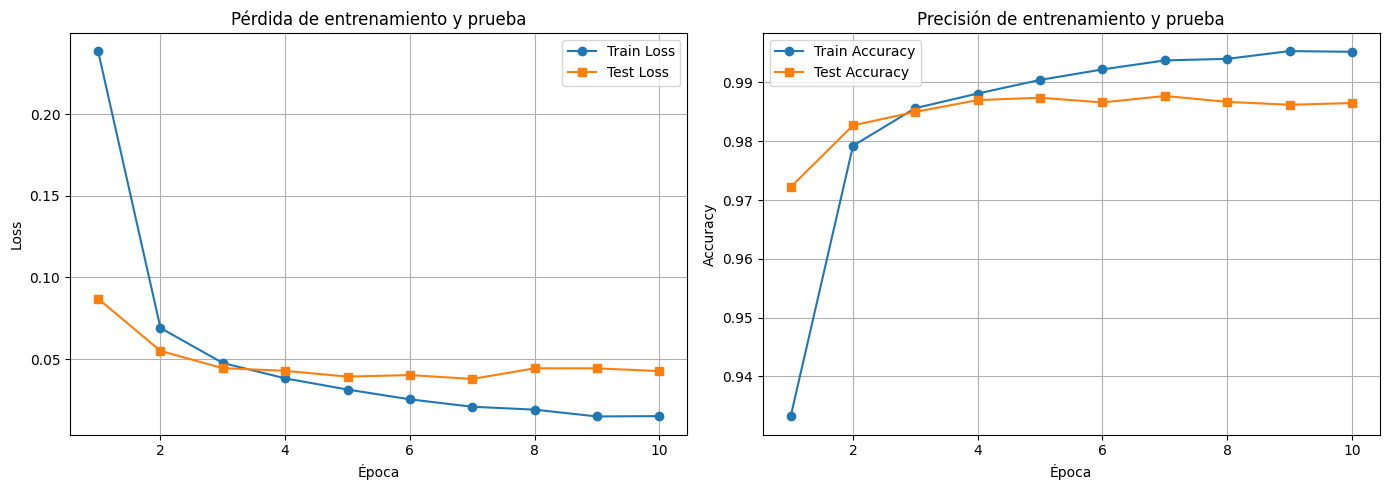

In [19]:
# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdidas
axes[0].plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, num_epochs+1), test_losses, label='Test Loss', marker='s')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pérdida de entrenamiento y prueba')
axes[0].legend()
axes[0].grid(True)

# Gráfico de accuracy
axes[1].plot(range(1, num_epochs+1), train_accs, label='Train Accuracy', marker='o')
axes[1].plot(range(1, num_epochs+1), test_accs, label='Test Accuracy', marker='s')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Precisión de entrenamiento y prueba')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

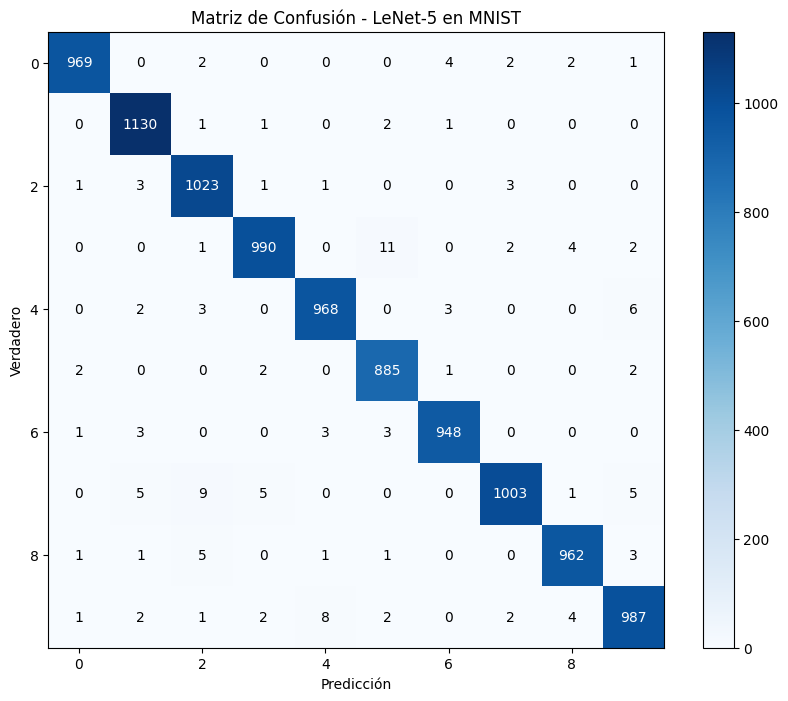


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [30]:
# Visualización de predicciones en ejemplos aleatorios
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Obtener predicciones en el conjunto de prueba
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - LeNet-5 en MNIST')

# Agregar anotaciones
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

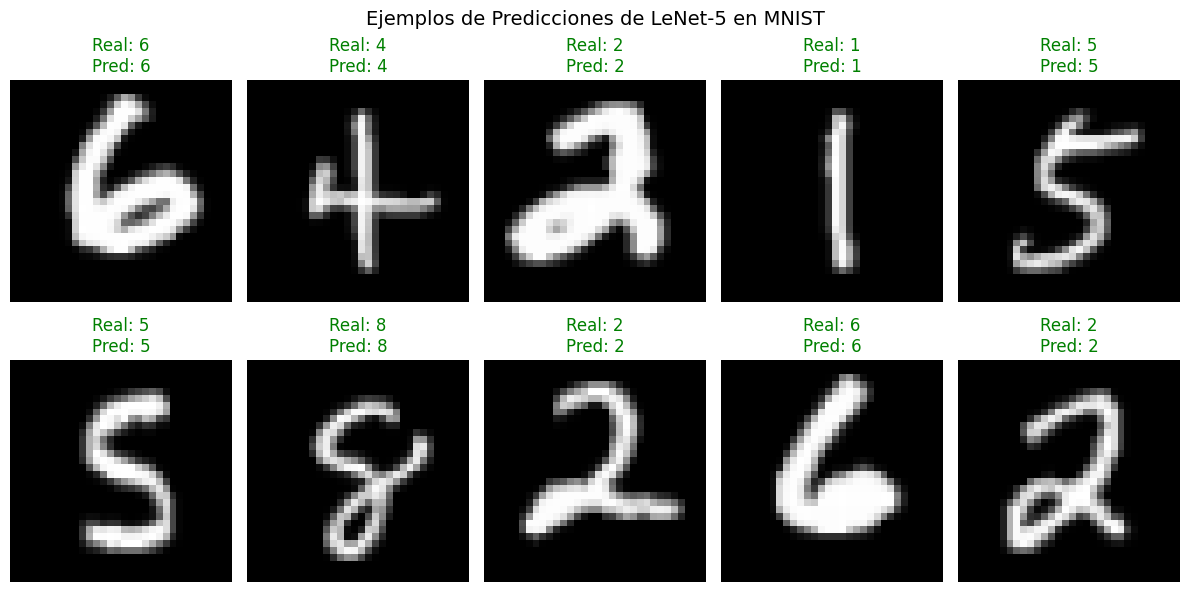


Modelo guardado como 'lenet5_mnist.pth'


In [29]:
# Visualizar ejemplos de predicciones
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# Obtener 10 ejemplos aleatorios del conjunto de prueba
indices = np.random.choice(len(test_dataset), 10, replace=False)

for i, idx in enumerate(indices):
    image, true_label = test_dataset[idx]
    
    # Hacer predicción
    model.eval()
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        _, predicted = torch.max(output, 1)
        pred_label = predicted.item()
    
    # Mostrar imagen
    img = image.squeeze().cpu().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Real: {true_label}\nPred: {pred_label}', 
                      color='green' if pred_label == true_label else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Ejemplos de Predicciones de LeNet-5 en MNIST', y=1.02, fontsize=14)
plt.show()

# Guardar el modelo
torch.save(model.state_dict(), 'lenet5_mnist.pth')
print("\nModelo guardado como 'lenet5_mnist.pth'")

## Problema 2

Lea el artículo de AlexNet [1].

**Fuente:** [A. Krizhevsky, I. Sutskever, G.E. Hinton, ImageNet Classification with Deep Convolutional Neural Networks, Advances in Neural Information Processing Systems 25, 2012](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html)

Resumen:
- LSVRC-2010
- 1000 clases diferentes
- Tasas de error top-1 y top-5 de 37.5% y 17.0%

Conclusiones:
Es notable que el rendimiento de su red se degrada si se elimina una sola capa convolucional.
Por ejemplo, eliminar cualquiera de las capas intermedias resulta en una pérdida de aproximadamente 2% en el rendimiento top-1 de la red. Así que la profundidad realmente es importante para lograr los resultados.

Introducción:

Hablan de que el peor rate error en MNIST es del (<0.3%) similar a humanos.

Habla de las implicaciones de entramiento y datasets grandes para poder probar redes profundas
menciona que al día de hoy con convoluciones optimizadas 2d se pueden entrenar redes profundas en datasets grandes.

Basicamente mencionan que crearon una red profunda con 5 capas convolucionales y 3 capas fully connected, con esto se arriesgaban a tener overfitting por la profundidad.

Por último hablan de el entrenamiento con 2 GPUS  GTX 580 3GB GPUs. Que tomo 5-6 días entrenar la red.

Dataset 

Usaron ImageNet, es un conjunto de datos con más de 15 millones de imágenes etiquetadas en 22,000 categorías. Para la competencia ILSVRC se usa un subconjunto de 1,000 clases con 1.2 millones de imágenes de entrenamiento. Las imágenes se redimensionan a 256×256 píxeles y se normalizan para adaptarse al modelo.

Arquitectura

La arquitectura de la red consta de ocho capas: cinco convolucionales y tres completamente conectadas. Utiliza unidades ReLU para acelerar el entrenamiento, normalización local para mejorar la generalización, y pooling superpuesto para reducir el sobreajuste. El modelo se distribuye en dos GPUs que se comunican selectivamente entre capas, lo que permite entrenar redes más grandes. La entrada es una imagen de 224×224×3, procesada por filtros convolucionales de distintos tamaños, y culmina en una capa softmax de 1000 salidas para clasificación.

Sobreajuste

Para reducir el sobreajuste, se aplicaron dos técnicas clave: aumento de datos (recortes, reflejos y variaciones de color) y dropout, que desactiva neuronas aleatoriamente durante el entrenamiento.

## Problema 3

Realice la implementación en Python de AlexNet y úsela para clasificar el conjunto de datos de [2]. Puede definir un problema de clasificación de su interés, como clasificar imágenes por temporada o similar.

**Fuente:** [https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)

In [6]:
import os
import kagglehub
import glob

path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

imagenes_dir = os.path.join(path, "images")

# Buscar todas las imágenes jpg en el directorio
imagenes = glob.glob(os.path.join(imagenes_dir, "*.jpg"))

# Mostrar cuántas imágenes se encontraron y ejemplo de rutas
print(f"Total de imágenes encontradas: {len(imagenes)}")

Total de imágenes encontradas: 44441


In [7]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, dropout_p=0.5):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            OrderedDict([
                # Capa CONV_1
                ('conv1', nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)),
                ('relu1', nn.ReLU(inplace=True)),
                ('maxpool1', nn.MaxPool2d(kernel_size=3, stride=2)),
                # Capa CONV_2
                ('conv2', nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)),
                ('relu2', nn.ReLU(inplace=True)),
                ('maxpool2', nn.MaxPool2d(kernel_size=3, stride=2)),
                # Capa CONV_3
                ('conv3', nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)),
                ('relu3', nn.ReLU(inplace=True)),
                # Capa CONV_4
                ('conv4', nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)),
                ('relu4', nn.ReLU(inplace=True)),
                # Capa CONV_5
                ('conv5', nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)),
                ('relu5', nn.ReLU(inplace=True)),
                ('maxpool5', nn.MaxPool2d(kernel_size=3, stride=2)),
            ])
        )

        # El paper original usa una imagen de entrada de 224x224.
        # Después de las capas convolucionales y de pooling, el tamaño de salida
        # de features para una entrada de 224x224x3 es 256x6x6.
        # Vamos a calcular esto dinámicamente o puedes usar 256 * 6 * 6
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) # Convierte cualquier tamaño a 6x6

        self.classifier = nn.Sequential(
            OrderedDict([
                ('dropout1', nn.Dropout(p=dropout_p)),
                ('fc1', nn.Linear(256 * 6 * 6, 4096)), # Primera capa FC
                ('relu6', nn.ReLU(inplace=True)),
                ('dropout2', nn.Dropout(p=dropout_p)),
                ('fc2', nn.Linear(4096, 4096)),       # Segunda capa FC
                ('relu7', nn.ReLU(inplace=True)),
                ('fc3', nn.Linear(4096, num_classes)), # Capa de salida
            ])
        )

    def forward(self, x):
        x = self.features(x)         # Pasa por el extractor de características (conv, relu, pool)
        x = self.avgpool(x)          # Ajusta el tamaño espacial a 6x6
        x = torch.flatten(x, 1)      # Aplanar la salida para la parte densa
        x = self.classifier(x)       # Pasa por el clasificador (FC, relu, dropout)
        return x
    
alex_net = AlexNet(num_classes=10).to(device)  

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim

# 1. Cargar las etiquetas
csv_path = os.path.join(path, "styles.csv")
# Usamos on_bad_lines='skip' porque este CSV en particular tiene algunos errores
df = pd.read_csv(csv_path, on_bad_lines='skip')

# Nos interesan el 'id' de la imagen y su 'articleType' (la clase)
df = df[['id', 'articleType']].copy()
df['id'] = df['id'].astype(str) + ".jpg" # Convertir ID a nombre de archivo (ej. 15970.jpg)
df = df.dropna() # Eliminar filas sin datos

# 2. Procesar etiquetas: Convertir texto a números
# 'factorize' nos da dos cosas:
# 1. 'labels': un array de números (0, 1, 2...)
# 2. 'unique_classes': la lista de nombres de las clases
df['label_idx'], unique_classes = pd.factorize(df['articleType'])
num_classes = len(unique_classes)

print(f"Total de clases encontradas: {num_classes}")
print(f"Ejemplo de mapeo: '{unique_classes[0]}' -> 0")

# Crear un diccionario (mapa) de id_imagen -> label_idx para acceso rápido
label_map = dict(zip(df['id'], df['label_idx']))


image_files_with_labels = []
image_labels = []

for img_path in imagenes:
    img_name = os.path.basename(img_path)
    if img_name in label_map:
        image_files_with_labels.append(img_path)
        image_labels.append(label_map[img_name])

print(f"Imágenes encontradas en disco: {len(imagenes)}")
print(f"Imágenes con etiqueta válida: {len(image_files_with_labels)}")

Total de clases encontradas: 143
Ejemplo de mapeo: 'Shirts' -> 0
Imágenes encontradas en disco: 44441
Imágenes con etiqueta válida: 44419


In [11]:
import numpy as np

labels_np = np.array(image_labels)
print("Valores únicos de etiquetas:", np.unique(labels_np))
print("Mínimo:", labels_np.min(), "Máximo:", labels_np.max())
print("num_classes:", num_classes)

# Corregir num_classes si es necesario
num_classes = int(labels_np.max()) + 1
print("num_classes corregido:", num_classes)

# Chequeo de rango
if labels_np.min() < 0 or labels_np.max() >= num_classes:
    print("¡Advertencia! Hay etiquetas fuera del rango válido para CrossEntropyLoss.")

Valores únicos de etiquetas: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142]
Mínimo: 0 Máximo: 142
num_classes: 143
num_classes corregido: 143


In [13]:
from tqdm import tqdm  
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import numpy as np

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path = "./"
num_classes = int(labels_np.max()) + 1 # Ajustar según tus etiquetas

# Dataset
class ListDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = list(file_paths)
        self.labels = list(labels)
        self.transform = transform
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = int(self.labels[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

# Transformaciones
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset completo
dataset_full = ListDataset(image_files_with_labels, image_labels, transform=transform)
print(f"Tamaño del dataset válido: {len(dataset_full)}")

# Split train/val
n_train = int(0.8 * len(dataset_full))
n_val = len(dataset_full) - n_train
train_ds, val_ds = random_split(dataset_full, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)


Tamaño del dataset válido: 44419


Tamaño del dataset válido: 44419
Valores únicos de etiquetas: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 142]
Mínimo: 0 Máximo: 142
num_classes: 143
Batch 0: images.shape=torch.Size([32, 3, 224, 224]), labels.shape=torch.Size([32])
Valores únicos de etiquetas: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51

Epoch 1 - train_loss: 1.7145 - val_loss: 0.9508 - train_acc: 0.5466 - val_acc: 0.7321


Epoch 2 - train_loss: 0.8888 - val_loss: 0.7979 - train_acc: 0.7372 - val_acc: 0.7544


Epoch 3 - train_loss: 0.7105 - val_loss: 0.6688 - train_acc: 0.7808 - val_acc: 0.7965


Epoch 4 - train_loss: 0.6052 - val_loss: 0.6466 - train_acc: 0.8073 - val_acc: 0.8011


Epoch 5 - train_loss: 0.5280 - val_loss: 0.5908 - train_acc: 0.8291 - val_acc: 0.8176


Epoch 6 - train_loss: 0.4700 - val_loss: 0.5263 - train_acc: 0.8453 - val_acc: 0.8333


Epoch 7 - train_loss: 0.4155 - val_loss: 0.5730 - train_acc: 0.8605 - val_acc: 0.8373


Epoch 8 - train_loss: 0.3702 - val_loss: 0.5454 - train_acc: 0.8731 - val_acc: 0.8455


Epoch 9 - train_loss: 0.3248 - val_loss: 0.5358 - train_acc: 0.8876 - val_acc: 0.8419


Epoch 10 - train_loss: 0.2972 - val_loss: 0.5095 - train_acc: 0.8955 - val_acc: 0.8495


Epoch 11 - train_loss: 0.2636 - val_loss: 0.5325 - train_acc: 0.9067 - val_acc: 0.8504


Epoch 12 - train_loss: 0.2316 - val_loss: 0.5297 - train_acc: 0.9158 - val_acc: 0.8480


Epoch 13 - train_loss: 0.2106 - val_loss: 0.5338 - train_acc: 0.9237 - val_acc: 0.8573


Epoch 14 - train_loss: 0.1895 - val_loss: 0.5792 - train_acc: 0.9310 - val_acc: 0.8473


Epoch 15 - train_loss: 0.1713 - val_loss: 0.5636 - train_acc: 0.9384 - val_acc: 0.8590


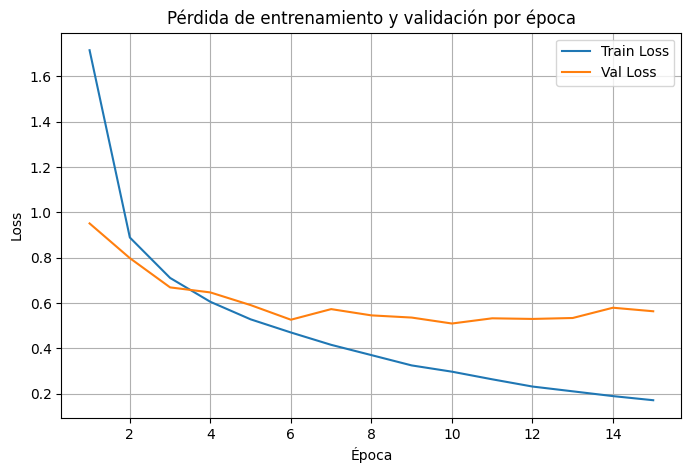

Modelo guardado en ./alexnet_fashion.pth


In [ ]:

# --- Celda de depuración para batches y etiquetas antes del entrenamiento ---
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Forzar errores CUDA sincrónicos

labels_np = np.array(image_labels)
print("Valores únicos de etiquetas:", np.unique(labels_np))
print("Mínimo:", labels_np.min(), "Máximo:", labels_np.max())
print("num_classes:", num_classes)

# Chequeo de rango y consistencia
assert labels_np.min() == 0, f"Etiqueta mínima inesperada: {labels_np.min()}"
assert labels_np.max() == num_classes - 1, f"Etiqueta máxima inesperada: {labels_np.max()} vs num_classes={num_classes}"
assert set(np.unique(labels_np)) <= set(range(num_classes)), "Hay etiquetas fuera del rango esperado"

# Probar un batch del DataLoader
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}: images.shape={images.shape}, labels.shape={labels.shape}")
    assert images.shape[0] == labels.shape[0], f"Batch mismatch: {images.shape[0]} vs {labels.shape[0]}"
    if images.isnan().any():
        print(f"¡Batch {i} con NaN en imágenes!")
    if labels.min() < 0 or labels.max() >= num_classes:
        print(f"¡Batch {i} con etiquetas fuera de rango!", labels)
    if i >= 2:
        break  # Solo probar los primeros 3 batches
print("Chequeo de batches completado. Si no hay errores, puedes entrenar con seguridad.")

# Modelo
model = AlexNet(num_classes=num_classes).to(device)  
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# Loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Entrenamiento con registro de pérdidas
num_epochs = 15
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(train_loss=running_loss/total, train_acc=correct/total)

    epoch_train_loss = running_loss / total
    train_losses.append(epoch_train_loss)

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
        for images, labels in loop_val:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            loop_val.set_postfix(val_acc=val_correct/val_total if val_total>0 else 0)

    epoch_val_loss = val_running_loss / val_total
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1} - train_loss: {epoch_train_loss:.4f} - val_loss: {epoch_val_loss:.4f} - train_acc: {correct/total:.4f} - val_acc: {val_correct/val_total:.4f}")

# Graficar pérdidas
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Pérdida de entrenamiento y validación por época')
plt.legend()
plt.grid(True)
plt.show()

# Guardar pesos
out_path = os.path.join(path, 'alexnet_fashion.pth')
torch.save(model.state_dict(), out_path)
print('Modelo guardado en', out_path)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Definir la arquitectura igual que en el entrenamiento
model = AlexNet(num_classes=num_classes)
model.classifier[6] = torch.nn.Linear(4096, num_classes)
model.load_state_dict(torch.load('alexnet_fashion.pth', map_location=device))
model = model.to(device)
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Accuracy y F1 macro
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Accuracy: {acc:.4f}')
print(f'F1 macro: {f1:.4f}')

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print('Matriz de confusión:')
print(cm)

Accuracy: 0.9438
F1 macro: 0.8697
Matriz de confusión:
[[660   0   0 ...   0   0   0]
 [  0 119   0 ...   0   0   0]
 [  0   0 479 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   1]]


## Problema 4

Lea el artículo de VGG-16 [3]. Escriba las similitudes y principales diferencias entre LeNet-5, AlexNet y VGG-16.

**Fuente:** [K. Simonyan, A. Zisserman, Very Deep Convolutional Networks for Large-Scale Image Recognition, arXiv:1409.1556, 2015](https://arxiv.org/abs/1409.1556)


| Característica         | LeNet-5 (Aprox. 1998)                    | AlexNet (2012)                          | VGG-16 (2014)                             |
|------------------------|------------------------------------------|-----------------------------------------|-------------------------------------------|
| Profundidad            | 7 capas (5 con pesos)                    | 8 capas (5 Conv + 3 FC)                 | 16 capas (13 Conv + 3 FC)                 |
| Conjunto de Datos      | MNIST (dígitos 32x32 B/N)                | ImageNet (imágenes 224x224 RGB)         | ImageNet (imágenes 224x224 RGB)           |
| Activación             | Sigmoid / Tanh                           | ReLU                                    | ReLU                                      |
| Tipo de Pooling        | Average Pooling (Subsampling)           | Max Pooling (Superpuesto)               | Max Pooling (No superpuesto)              |
| Tamaño de Filtros      | 5×5                                      | Grandes y variados (11×11, 5×5, 3×3)    | Muy pequeños y uniformes (3×3)            |
| Regularización         | N/A (modelo pequeño)                     | Dropout, Aumento de Datos               | Dropout, Aumento de Datos (Scale Jitter)  |
| Normalización          | Ninguna                                  | Local Response Normalization (LRN)      | Ninguna (LRN se probó y descartó)         |
| Parámetros             | ~60,000                                  | ~60 millones                            | ~138 millones (Config. D)                 |




Yo lo que veo en similitudes es:

- Que todas son CNNs para clasificación de imágenes.
- Usan capas convolucionales seguidas de pooling.
- Utilizan capas totalmente conectadas al final.

Lo que veo de diferencias es:

- Que LeNet- 5 es más simple y además de que utiliza una función de activación sigmoide o tanh, mientras que AlexNet y VGG-16 usan ReLU.
- AlexNet y VGG-16 son mucho más profundas que LeNet-5, con 8 y 16 capas respectivamente.
- AlexNet utiliza normalización local de respuesta (LRN), mientras que LeNet-5 y VGG-16 no la usan.
- La cantidad de parametros varía exponencialmente, siendo LeNet-5 la más pequeña y VGG-16 la más grande.

---

## Referencias

[1] A. Krizhevsky, I. Sutskever, G.E. Hinton, *ImageNet Classification with Deep Convolutional Neural Networks*, Advances in Neural Information Processing Systems 25, 2012.

[2] Fashion Product Images (Small) Dataset: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small

[3] K. Simonyan, A. Zisserman, *Very Deep Convolutional Networks for Large-Scale Image Recognition*, arXiv:1409.1556, 2015.

In [31]:
!jupyter nbconvert --to html Tarea1.ipynb

[NbConvertApp] Converting notebook Tarea1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 651143 bytes to Tarea1.html
